In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import theano
import theano.tensor as T

import src.pyFWRF as prf
import src.pyNumpyUtility as pnu
from   src.pyFWRF import FWRF_model, fpX

Couldn't import dot_parser, loading of dot files will not be possible.
theano floatX: float32
numpy floatX: <type 'numpy.float32'>


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"

print "Time Stamp: %s" % timestamp

Time Stamp: Mar-24-2017_1455


In [3]:
def save_stuff(save_to_this_file, data_objects_dict):
    failed = []
    with h5py.File(save_to_this_file+'.h5py', 'w') as hf:
        for k,v in data_objects_dict.iteritems():
            try:
                hf.create_dataset(k,data=v)
                print 'saved %s in h5py file' %(k)
            except:
                failed.append(k)
                print 'failed to save %s as h5py. will try pickle' %(k)   
    for k in failed:
        with open(save_to_this_file+'_'+'%s.pkl' %(k), 'w') as pkl:
            try:
                pickle.dump(data_objects_dict[k],pkl)
                print 'saved %s as pkl' %(k)
            except:
                print 'failed to save %s in any format. lost.' %(k)
                
def display_candidate_loss(scores, nx, ny, ns):
    dis_y = ns // 3 if ns%3==0 else ns//3+1
    s = scores.reshape((nx, ny, ns)).transpose((1,0,2))[::-1,:,:] ## The transpose and flip is just so that the candidate 
    #coordinate maatch the normal cartesian coordinate of the rf position when viewed through imshow.
    idxs = np.unravel_index(np.argmin(s), (nx,ny,ns))
    best = plt.Circle((idxs[1], idxs[0]), 0.5, color='r', fill=False, lw=2)
    
    fig = plt.figure(figsize=(15, 5*dis_y))
    smin = np.min(s)
    smax = np.max(s)
    print "score range = (%f, %f)" % (smin, smax)
    for i in range(ns):
        plt.subplot(dis_y, 3, i+1)
        plt.imshow(s[:,:,i], interpolation='None')
        plt.title('sigma canditate = %d' % i)
        plt.clim(smin, smax)
        if(idxs[2]==i):
            ax = plt.gca()
            ax.add_artist(best)
    return fig

# 1a) Load the image dataset (the images that were presented to the subject for which we have voxel data)

## Load vim-1 dataset

In [4]:
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

In [5]:
stimuli_lowrez = sio.loadmat(dataset_dir+"Stimuli.mat") ### this loads a low-rez version of the stimuli
print stimuli_lowrez.keys()

trn_size = len(stimuli_lowrez["stimTrn"])
val_size = len(stimuli_lowrez["stimVal"])
data_size = trn_size + val_size

print "trn: %d, val: %d" % (trn_size, val_size)

['seqTrn', '__header__', '__globals__', 'stimVal', 'seqVal', 'stimTrn', '__version__']
trn: 1750, val: 120


In [6]:
train_stim_files = glob(dataset_dir+"Stimuli_Trn_FullRes*.mat")
val_stim_file = dataset_dir+"Stimuli_Val_FullRes.mat"

In [7]:
##load validation stim
val_h5 = h5py.File(val_stim_file,'r')
val_stimuli_hirez = np.transpose(val_h5['stimVal'][:],[2,1,0]).astype(fpX)
val_h5.close()

##allocate memory for stim
hirez_resolution = val_stimuli_hirez.shape[1:3]
trn_stimuli_hirez = np.zeros((trn_size,)+hirez_resolution ,dtype=fpX)

##load training stim
cnt = 0
for sl in sorted(train_stim_files):
    this_h5 = h5py.File(sl,'r')
    this_train_stim = this_h5['stimTrn']
    this_num_stim = this_train_stim.shape[-1]
    trn_stimuli_hirez[cnt:cnt+this_num_stim,:,:] = np.transpose(this_train_stim[:],[2,1,0])
    cnt += this_num_stim
    this_h5.close()

## Convert to resolution of the network input

In [8]:
npx = 227
npc = 1

#trn_source = stimuli_lowrez["stimTrn"]
#val_source = stimuli_lowrez["stimVal"]
trn_source = trn_stimuli_hirez
val_source = val_stimuli_hirez

inputData = np.ndarray(shape=(data_size, npx, npx, npc), dtype=fpX)

for i,rawim in enumerate(trn_source):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)               
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    
    inputData[i,...] = np.mean(np.asarray(im), axis=2, keepdims=True)

for i,rawim in enumerate(val_source):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)         
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    inputData[trn_size+i,...] = np.mean(np.asarray(im), axis=2, keepdims=True)
        
inputData = np.transpose((inputData - 128) / 128, (0,3,1,2))
print "Data shape = %s" % (inputData.shape,)

trnInputData = inputData[:trn_size]
valInputData = inputData[trn_size:]

Data shape = (1870, 1, 227, 227)


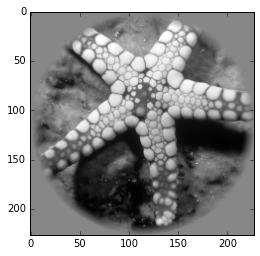

In [9]:
plt.imshow(trnInputData[5,0,:,:], cmap='gray')

# 1b) Load the corresponding voxel data

In [10]:
voxelset = h5py.File(dataset_dir+"EstimatedResponses.mat")
print voxelset.keys()

[u'dataTrnS1', u'dataTrnS2', u'dataValS1', u'dataValS2', u'roiS1', u'roiS2', u'voxIdxS1', u'voxIdxS2']


In [11]:
subject = 'S1'
roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']

In [12]:
voxeldata = np.concatenate([voxelset['dataTrn%s'%subject], voxelset['dataVal%s'%subject]], axis=0).astype(dtype=fpX)
voxelroi = voxelset['roi%s'%subject]
voxelidx = voxelset['voxIdx%s'%subject]
print voxeldata.shape

voxelNanMask = ~np.isnan(voxeldata).any(axis=0)
nv = np.sum(voxelNanMask)
print "%d voxels contain valid values for all images" % nv

(1870, 25915)
22701 voxels contain valid values for all images


In [13]:
voxelData = voxeldata[:, voxelNanMask].astype(dtype=fpX)
voxelROI  = voxelroi[:, voxelNanMask]
voxelIDX  = voxelidx[:, voxelNanMask]
print voxelData.shape

trnVoxelData = voxelData[:trn_size]
valVoxelData = voxelData[trn_size:]

(1870, 22701)


### (Optional) Restricted set of voxels

In [66]:
nv = 1000
start_v = (3566 // nv) * nv
trnVoxelData = trnVoxelData[:, start_v:start_v+nv]
valVoxelData = valVoxelData[:, start_v:start_v+nv]

# 0) Create the feature space and generate the feature maps for the dataset

In [14]:
model_name = 'gabor'
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps

In [15]:
n_orientations = 4
deg_per_stimulus = 20.
lowest_sp_freq = .25 ##cyc/deg
highest_sp_freq = 6. #4.664387 #6.25
num_sp_freq = 12
pix_per_cycle = 3.13333333
complex_cell = True

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)

D = total number of features = 48


In [16]:
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle,complex_cell=complex_cell,
                         diams_per_filter = 4,
                         cycles_per_radius = 1.)

/home/styvesg/Documents/PostDoc/Programs/hrf_fitting/src/gabor_feature_dictionaries.py:120: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  filter_stack = np.zeros((gbr_table.shape[0],color_channels,pix_per_filter,pix_per_filter))


In [17]:
print gfm.filter_stack.shape
gfm.gbr_table.head(17)

(48, 1, 25, 25)


,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.250000,8,32.000000,15.666667,25,4.000000,0.000000
1,0.333744,8,23.970452,20.914638,25,2.996307,0.000000
2,0.445541,8,17.955706,27.920558,25,2.244463,0.000000
3,0.594787,8,13.450200,37.273300,25,1.681275,0.000000
4,0.794027,8,10.075230,49.758995,25,1.259404,0.000000
5,1.060007,8,7.547120,66.427109,25,0.943390,0.000000
6,1.415085,8,5.653371,88.678655,25,0.706671,0.000000
7,1.889106,8,4.234808,118.383956,25,0.529351,0.000000
8,2.521912,8,3.172196,158.039846,25,0.396524,0.000000
9,3.366695,8,2.376218,210.979542,25,0.297027,0.000000


float64
(48, 1, 25, 25)


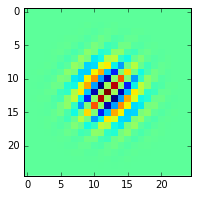

In [18]:
print np.real(gfm.filter_stack).dtype

#complex fs = np.stack([np.real(gfm.filter_stack), np.imag(gfm.filter_stack), np.zeros(shape=gfm.filter_stack.shape)]).transpose([1,2,3,4,0])
fs = np.real(gfm.filter_stack)
print fs.shape 
fig=plt.figure(figsize=(3,3))
plt.imshow(fs[15, 0, :, :], interpolation='None')

In [19]:
#filename = output_dir + "gabor_example.png"
#fig.patch.set_alpha(0.)
#fig.savefig(filename)
#plt.close()

In [20]:
##construct the model space
feat_dict = gfm.create_feature_maps(inputData)

allocating memory for feature maps
constructing feature maps
feature 0 took 0.239611 s.
feature 1 took 0.255562 s.
feature 2 took 0.291474 s.
feature 3 took 0.386861 s.
feature 4 took 0.602336 s.
feature 5 took 1.013560 s.
feature 6 took 1.843021 s.
feature 7 took 3.338339 s.
feature 8 took 6.199494 s.
feature 9 took 11.461711 s.
feature 10 took 21.131442 s.
feature 11 took 38.355159 s.
feature 12 took 0.227905 s.
feature 13 took 0.247263 s.
feature 14 took 0.289613 s.
feature 15 took 0.385057 s.
feature 16 took 0.604396 s.
feature 17 took 1.012488 s.
feature 18 took 1.844466 s.
feature 19 took 3.337040 s.
feature 20 took 6.208180 s.
feature 21 took 11.451086 s.
feature 22 took 21.051811 s.
feature 23 took 38.264469 s.
feature 24 took 0.223716 s.
feature 25 took 0.245734 s.
feature 26 took 0.289337 s.
feature 27 took 0.383844 s.
feature 28 took 0.603232 s.
feature 29 took 1.010783 s.
feature 30 took 1.841283 s.
feature 31 took 3.334752 s.
feature 32 took 6.207158 s.
feature 33 took 11.

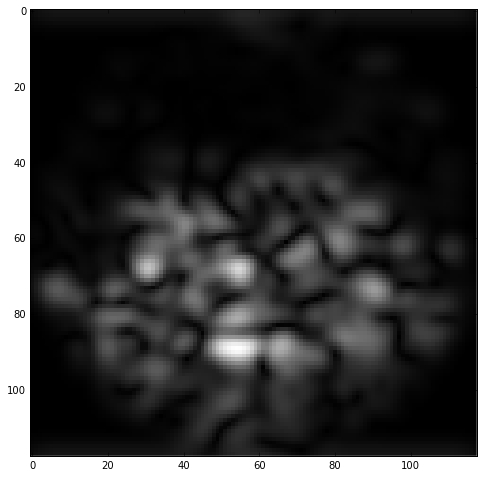

In [21]:
fmn = 7
fig=plt.figure(figsize=(8,8))
plt.imshow(feat_dict[fmn][3,0,:,:], cmap='gray', interpolation='None')

## Concatenate feature maps of the same resolution

In [22]:
fmap_rez = []
for k in feat_dict.keys():
    fmap_rez += [feat_dict[k].shape[2],]
resolutions = np.unique(fmap_rez)
print resolutions
## we should concatenate those that have the same resolutions

[ 16  21  28  37  50  66  89 118 158 211 282 376]


In [23]:
#activation function applied to the convolved images.
log_act_func = lambda x: np.log(1+np.sqrt(x))

# concatenate and sort as list
fmaps_res_count = len(resolutions)
fmaps_count = 0
fmaps = []
for r in range(fmaps_res_count):
    fmaps += [[],] #needs to be set manually
fmaps_sizes = []

for k in feat_dict.keys():
    # determine which resolution idx this map belongs to
    ridx = np.argmax(resolutions==feat_dict[k].shape[2])
    if len(fmaps[ridx])==0:
        fmaps[ridx] = log_act_func(feat_dict[k].astype(fpX))
    else:
        fmaps[ridx] = np.concatenate((fmaps[ridx], log_act_func(feat_dict[k].astype(fpX))), axis=1)       
    fmaps_count += 1
    
for fmap in fmaps:
    fmaps_sizes += [fmap.shape]
print fmaps_sizes
print "total fmaps = %d" % fmaps_count

[(1870, 4, 16, 16), (1870, 4, 21, 21), (1870, 4, 28, 28), (1870, 4, 37, 37), (1870, 4, 50, 50), (1870, 4, 66, 66), (1870, 4, 89, 89), (1870, 4, 118, 118), (1870, 4, 158, 158), (1870, 4, 211, 211), (1870, 4, 282, 282), (1870, 4, 376, 376)]
total fmaps = 48


In [24]:
# aliases
nf = fmaps_count
allFmaps = fmaps

# make sure we are using float32
print allFmaps[0].dtype

float32


In [25]:
del feat_dict

# 2) MODELS

## Define the inputs
We can either connect the feature maps of the network directly or some precomputed values provided in a suitable list

In [26]:
#feature maps symbolic variables
_fmaps = []
for r in range(fmaps_res_count):
    _fmaps += [T.tensor4(),] # note this has to be done explicitely, we can't just replicate the tensor object
_invar = _fmaps
# vs.
#_fmaps = [L.get_output(fm, deterministic=True) for fm in _aux]
#_invar = [X,]

## Define the search parameters

In [27]:
lx = ly = 20.
nx = ny = 26
smin, smax = 0.5, 8.
ns = 12

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
sharedModel_specs = [[(0., lx), (0., ly), (smin, smax)], [prf.linspace(nx), prf.linspace(ny), prf.logspace(ns)]]
# initial values of the fwrf model parameters
voxelParams = [np.full(shape=(nv, nf), fill_value=0.0, dtype=fpX), np.full(shape=(nv), fill_value=0.0, dtype=fpX)]

print "G = %d\n" % (nx*ny*ns)
#print range:
print "range x"
print sharedModel_specs[1][0](*sharedModel_specs[0][0])
print "range y"
print sharedModel_specs[1][1](*sharedModel_specs[0][1])
print "range s"
print sharedModel_specs[1][2](*sharedModel_specs[0][2])



G = 8112

range x
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range y
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range s
[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


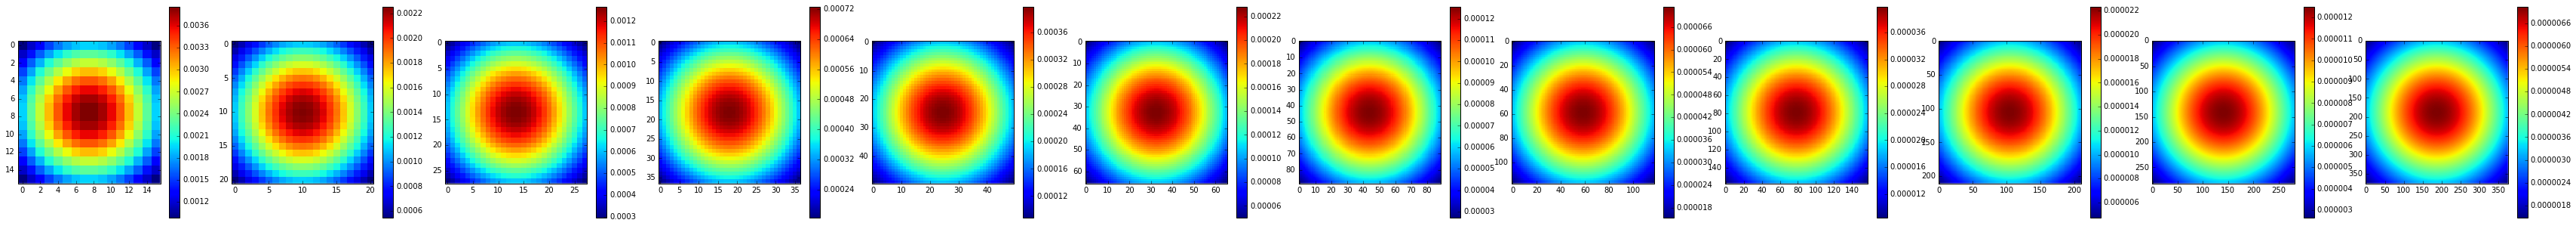

In [56]:
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
print sigmas

ith_rf_size = 11
n = len(fmaps_sizes)
plt.figure(figsize=(5*n,5))
for i,r in enumerate(fmaps_sizes):
    _,_,z = pnu.make_gaussian_mass(0., 0., sigmas[ith_rf_size], r[2], size=20.)
    plt.subplot(1,n,i+1)
    plt.imshow(z, interpolation='None')
    plt.colorbar()

(0, 10)

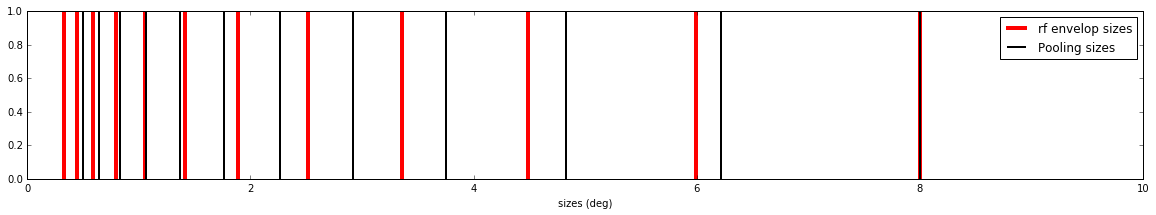

In [57]:
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
env = 2. / np.logspace(np.log10(lowest_sp_freq),np.log10(highest_sp_freq), num_sp_freq)

fig_1 = plt.figure(figsize=(20,3))
plt.vlines(env, 0., 1., lw=4, color='r', label='rf envelop sizes')
plt.vlines(sigmas, 0., 1., lw=2, color='k', label='Pooling sizes')
#plt.xscale('log')
plt.xlabel('sizes (deg)')
plt.legend()
plt.xlim([0, 10])

## Define the model
This model needs to be batched at different stages

In [28]:
fwrf = FWRF_model(_fmaps, fmaps_sizes, _invar, fmaps_sizes,
    batches_p=(500, ny*nx), batches_o=(200, 1000, 2*ny*nx), batches_t=(500, 2*ny*nx),\
    view_angle=lx, verbose=True)

CREATING SYMBOLS

> rfw 0 with shape (1, 676, 16, 16)
> rfw 1 with shape (1, 676, 21, 21)
> rfw 2 with shape (1, 676, 28, 28)
> rfw 3 with shape (1, 676, 37, 37)
> rfw 4 with shape (1, 676, 50, 50)
> rfw 5 with shape (1, 676, 66, 66)
> rfw 6 with shape (1, 676, 89, 89)
> rfw 7 with shape (1, 676, 118, 118)
> rfw 8 with shape (1, 676, 158, 158)
> rfw 9 with shape (1, 676, 211, 211)
> rfw 10 with shape (1, 676, 282, 282)
> rfw 11 with shape (1, 676, 376, 376)
  total number of feature maps = 48, in 12 layers
  shared rfw using approx 830.2 Mb of memory (VRAM and RAM)


Layer	: <lasagne.layers.input.InputLayer object at 0x7f07bac3fb10>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 48, 1352)


Layer	: <src.pyFWRF.svFWRFLayer object at 0x7f07bac3fbd0>
Name	: None
Type	: <class 'src.pyFWRF.svFWRFLayer'>
Shape	: (None, 1000, 1352)
Params
        |-- W         : (48, 1000, 1352)
        |-- b         : (1, 1000, 1352)



COMPILING...
6.96 seconds to compile theano

## Precompute and save the modelspace tensor

In [29]:
all_rfw_data = fwrf.precompute_rfw_data(allFmaps, sharedModel_specs, verbose=True, dry_run=False, zscore=True, trn_size=trn_size, epsilon=1e-3)


>> Storing the full precomputed candidate feature time series will require approx 2.713Gb of RAM!
>> Will be divided in chunks of 0.452Gb of VRAM!

Precomputing rfw candidate responses...


100%|██████████| 12/12 [02:27<00:00, 12.24s/it]

8112 rfw candidate responses took 147.196s @ 55.110 models/s
Z-scoring modelspace tensor...



12it [00:11,  1.08it/s]


In [30]:
print all_rfw_data.shape
print np.amin(all_rfw_data), np.amax(all_rfw_data)

(1870, 48, 1, 8112)
-7.56205 9.55846


In [31]:
trn_rfw_data = all_rfw_data[:trn_size]
val_rfw_data = all_rfw_data[trn_size:]

## Run the models

In [32]:
lr = 1e-3 #2e-6
num_epochs = 20

val_scores, best_scores, best_abs_models, best_rel_models, best_params = fwrf.shared_model_training(\
    trn_rfw_data, trnVoxelData, sharedModel_specs, voxelParams,\
    val_test_size=350, lr=lr, l2=0., num_epochs=num_epochs, output_val_scores=True, verbose=True, dry_run=False, use_data_as_rfw_data=True)


Voxel-Candidates model optimization...
22 voxel batches of size 1000 with residual 701
6 candidate batches of size 1352 with residual 0
for 184150512 voxelmodel fits.


0it [00:00, ?it/s]


  Voxel 0:1000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005713
    validation <loss>: 0.005713
    validation <loss>: 0.005713
    validation <loss>: 0.005713
    validation <loss>: 0.005713
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    validation <loss>: 0.005717
    validation <loss>: 0.005717
    validation <loss>: 0.005717
    20 Epoch for 1352000 voxelmodels took 72.001s @ 18777.394 voxelmodels/s

  Voxel 0:1000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005713
    validation <loss>: 0.005712
    validation <loss>: 0.005712
    validation <loss>: 0.005713
    validation <loss>: 0.005713
    validation <los

1it [07:15, 435.31s/it]


  Voxel 1000:2000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005715
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    20 Epoch for 1352000 voxelmodels took 72.171s @ 18733.205 voxelmodels/s

  Voxel 1000:2000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005714
    validation <loss>: 0.005713
    validation <loss>: 0.005712
    validation <loss>: 0.005712
    validation <loss>: 0.005712
    validatio

2it [14:30, 435.41s/it]


  Voxel 2000:3000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005730
    validation <loss>: 0.005731
    validation <loss>: 0.005732
    validation <loss>: 0.005732
    validation <loss>: 0.005733
    validation <loss>: 0.005734
    validation <loss>: 0.005734
    validation <loss>: 0.005735
    validation <loss>: 0.005735
    validation <loss>: 0.005735
    validation <loss>: 0.005736
    validation <loss>: 0.005736
    validation <loss>: 0.005737
    validation <loss>: 0.005737
    validation <loss>: 0.005737
    validation <loss>: 0.005738
    validation <loss>: 0.005738
    validation <loss>: 0.005739
    validation <loss>: 0.005739
    validation <loss>: 0.005739
    20 Epoch for 1352000 voxelmodels took 71.962s @ 18787.599 voxelmodels/s

  Voxel 2000:3000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005730
    validation <loss>: 0.005731
    validation <loss>: 0.005732
    validation <loss>: 0.005733
    validation <loss>: 0.005733
    validatio

3it [21:46, 435.35s/it]


  Voxel 3000:4000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005732
    validation <loss>: 0.005729
    validation <loss>: 0.005728
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    20 Epoch for 1352000 voxelmodels took 71.930s @ 18796.130 voxelmodels/s

  Voxel 3000:4000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005730
    validation <loss>: 0.005726
    validation <loss>: 0.005725
    validation <loss>: 0.005724
    validation <loss>: 0.005723
    validatio

4it [29:01, 435.42s/it]


  Voxel 4000:5000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005733
    validation <loss>: 0.005734
    validation <loss>: 0.005735
    validation <loss>: 0.005735
    validation <loss>: 0.005736
    validation <loss>: 0.005737
    validation <loss>: 0.005737
    validation <loss>: 0.005738
    validation <loss>: 0.005738
    validation <loss>: 0.005739
    validation <loss>: 0.005739
    validation <loss>: 0.005739
    validation <loss>: 0.005740
    validation <loss>: 0.005740
    validation <loss>: 0.005741
    validation <loss>: 0.005741
    validation <loss>: 0.005741
    validation <loss>: 0.005742
    validation <loss>: 0.005742
    validation <loss>: 0.005743
    20 Epoch for 1352000 voxelmodels took 72.091s @ 18754.177 voxelmodels/s

  Voxel 4000:5000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005733
    validation <loss>: 0.005734
    validation <loss>: 0.005735
    validation <loss>: 0.005736
    validation <loss>: 0.005736
    validatio

5it [36:16, 435.24s/it]


  Voxel 5000:6000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005735
    validation <loss>: 0.005732
    validation <loss>: 0.005730
    validation <loss>: 0.005729
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005729
    20 Epoch for 1352000 voxelmodels took 72.105s @ 18750.433 voxelmodels/s

  Voxel 5000:6000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005733
    validation <loss>: 0.005728
    validation <loss>: 0.005726
    validation <loss>: 0.005724
    validation <loss>: 0.005724
    validatio

6it [43:31, 435.29s/it]


  Voxel 6000:7000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005751
    validation <loss>: 0.005752
    validation <loss>: 0.005752
    validation <loss>: 0.005753
    validation <loss>: 0.005753
    validation <loss>: 0.005754
    validation <loss>: 0.005754
    validation <loss>: 0.005754
    validation <loss>: 0.005755
    validation <loss>: 0.005755
    validation <loss>: 0.005755
    validation <loss>: 0.005756
    validation <loss>: 0.005756
    validation <loss>: 0.005757
    validation <loss>: 0.005757
    validation <loss>: 0.005757
    validation <loss>: 0.005758
    validation <loss>: 0.005758
    20 Epoch for 1352000 voxelmodels took 72.137s @ 18742.079 voxelmodels/s

  Voxel 6000:7000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005751
    validation <loss>: 0.005752
    validation <loss>: 0.005752
    validatio

7it [50:47, 435.39s/it]


  Voxel 7000:8000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005740
    validation <loss>: 0.005735
    validation <loss>: 0.005733
    validation <loss>: 0.005732
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    20 Epoch for 1352000 voxelmodels took 72.118s @ 18746.925 voxelmodels/s

  Voxel 7000:8000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005737
    validation <loss>: 0.005732
    validation <loss>: 0.005729
    validation <loss>: 0.005727
    validation <loss>: 0.005726
    validatio

8it [58:02, 435.21s/it]


  Voxel 8000:9000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005758
    validation <loss>: 0.005758
    validation <loss>: 0.005759
    validation <loss>: 0.005760
    validation <loss>: 0.005760
    validation <loss>: 0.005761
    validation <loss>: 0.005761
    validation <loss>: 0.005762
    validation <loss>: 0.005762
    validation <loss>: 0.005762
    validation <loss>: 0.005763
    validation <loss>: 0.005763
    validation <loss>: 0.005763
    validation <loss>: 0.005764
    validation <loss>: 0.005764
    validation <loss>: 0.005764
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005766
    20 Epoch for 1352000 voxelmodels took 72.036s @ 18768.272 voxelmodels/s

  Voxel 8000:9000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005758
    validation <loss>: 0.005758
    validation <loss>: 0.005759
    validation <loss>: 0.005760
    validation <loss>: 0.005760
    validatio

9it [1:05:17, 435.26s/it]


  Voxel 9000:10000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005737
    validation <loss>: 0.005732
    validation <loss>: 0.005730
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    20 Epoch for 1352000 voxelmodels took 71.885s @ 18807.691 voxelmodels/s

  Voxel 9000:10000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005734
    validation <loss>: 0.005729
    validation <loss>: 0.005726
    validation <loss>: 0.005724
    validation <loss>: 0.005723
    validat

10it [1:12:32, 435.22s/it]


  Voxel 10000:11000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005769
    validation <loss>: 0.005769
    validation <loss>: 0.005769
    validation <loss>: 0.005770
    validation <loss>: 0.005770
    validation <loss>: 0.005771
    validation <loss>: 0.005771
    validation <loss>: 0.005772
    validation <loss>: 0.005772
    validation <loss>: 0.005773
    validation <loss>: 0.005773
    validation <loss>: 0.005773
    validation <loss>: 0.005774
    validation <loss>: 0.005774
    validation <loss>: 0.005774
    validation <loss>: 0.005775
    validation <loss>: 0.005775
    validation <loss>: 0.005776
    validation <loss>: 0.005776
    validation <loss>: 0.005776
    20 Epoch for 1352000 voxelmodels took 72.030s @ 18770.071 voxelmodels/s

  Voxel 10000:11000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005768
    validation <loss>: 0.005768
    validation <loss>: 0.005768
    validation <loss>: 0.005769
    validation <loss>: 0.005769
    valid

11it [1:19:47, 435.07s/it]


  Voxel 11000:12000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005735
    validation <loss>: 0.005732
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005732
    validation <loss>: 0.005732
    validation <loss>: 0.005732
    validation <loss>: 0.005732
    validation <loss>: 0.005732
    validation <loss>: 0.005733
    20 Epoch for 1352000 voxelmodels took 71.820s @ 18824.759 voxelmodels/s

  Voxel 11000:12000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005734
    validation <loss>: 0.005731
    validation <loss>: 0.005730
    validation <loss>: 0.005729
    validation <loss>: 0.005729
    valid

12it [1:27:03, 435.18s/it]


  Voxel 12000:13000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005754
    validation <loss>: 0.005751
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005751
    validation <loss>: 0.005751
    validation <loss>: 0.005751
    validation <loss>: 0.005751
    validation <loss>: 0.005752
    validation <loss>: 0.005752
    validation <loss>: 0.005752
    validation <loss>: 0.005753
    validation <loss>: 0.005753
    validation <loss>: 0.005753
    validation <loss>: 0.005754
    validation <loss>: 0.005754
    validation <loss>: 0.005754
    validation <loss>: 0.005755
    20 Epoch for 1352000 voxelmodels took 71.926s @ 18796.995 voxelmodels/s

  Voxel 12000:13000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005752
    validation <loss>: 0.005749
    validation <loss>: 0.005748
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    valid

13it [1:34:17, 435.09s/it]


  Voxel 13000:14000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005767
    validation <loss>: 0.005767
    validation <loss>: 0.005767
    validation <loss>: 0.005767
    validation <loss>: 0.005767
    validation <loss>: 0.005767
    validation <loss>: 0.005767
    validation <loss>: 0.005767
    validation <loss>: 0.005768
    validation <loss>: 0.005768
    validation <loss>: 0.005768
    validation <loss>: 0.005768
    validation <loss>: 0.005768
    validation <loss>: 0.005768
    validation <loss>: 0.005769
    validation <loss>: 0.005769
    validation <loss>: 0.005769
    validation <loss>: 0.005769
    validation <loss>: 0.005770
    validation <loss>: 0.005770
    20 Epoch for 1352000 voxelmodels took 72.018s @ 18772.954 voxelmodels/s

  Voxel 13000:14000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005767
    validation <loss>: 0.005766
    validation <loss>: 0.005766
    validation <loss>: 0.005766
    validation <loss>: 0.005766
    valid

14it [1:41:33, 435.11s/it]


  Voxel 14000:15000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005757
    validation <loss>: 0.005752
    validation <loss>: 0.005749
    validation <loss>: 0.005748
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005748
    validation <loss>: 0.005748
    validation <loss>: 0.005748
    validation <loss>: 0.005748
    20 Epoch for 1352000 voxelmodels took 71.942s @ 18792.828 voxelmodels/s

  Voxel 14000:15000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005755
    validation <loss>: 0.005748
    validation <loss>: 0.005745
    validation <loss>: 0.005743
    validation <loss>: 0.005742
    valid

15it [1:48:48, 435.11s/it]


  Voxel 15000:16000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005787
    validation <loss>: 0.005787
    validation <loss>: 0.005788
    validation <loss>: 0.005789
    validation <loss>: 0.005790
    validation <loss>: 0.005790
    validation <loss>: 0.005790
    validation <loss>: 0.005791
    validation <loss>: 0.005791
    validation <loss>: 0.005792
    validation <loss>: 0.005792
    validation <loss>: 0.005792
    validation <loss>: 0.005792
    validation <loss>: 0.005793
    validation <loss>: 0.005793
    validation <loss>: 0.005793
    validation <loss>: 0.005794
    validation <loss>: 0.005794
    validation <loss>: 0.005794
    validation <loss>: 0.005795
    20 Epoch for 1352000 voxelmodels took 72.204s @ 18724.784 voxelmodels/s

  Voxel 15000:16000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005786
    validation <loss>: 0.005787
    validation <loss>: 0.005787
    validation <loss>: 0.005788
    validation <loss>: 0.005789
    valid

16it [1:56:03, 435.09s/it]


  Voxel 16000:17000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005772
    validation <loss>: 0.005768
    validation <loss>: 0.005766
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005764
    validation <loss>: 0.005764
    validation <loss>: 0.005764
    validation <loss>: 0.005764
    validation <loss>: 0.005764
    validation <loss>: 0.005764
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005765
    validation <loss>: 0.005766
    20 Epoch for 1352000 voxelmodels took 71.945s @ 18792.158 voxelmodels/s

  Voxel 16000:17000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005770
    validation <loss>: 0.005764
    validation <loss>: 0.005762
    validation <loss>: 0.005761
    validation <loss>: 0.005760
    valid

17it [2:03:18, 435.08s/it]


  Voxel 17000:18000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005755
    validation <loss>: 0.005752
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005749
    validation <loss>: 0.005749
    validation <loss>: 0.005749
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005751
    validation <loss>: 0.005751
    validation <loss>: 0.005751
    validation <loss>: 0.005751
    validation <loss>: 0.005752
    validation <loss>: 0.005752
    20 Epoch for 1352000 voxelmodels took 72.202s @ 18725.174 voxelmodels/s

  Voxel 17000:18000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005753
    validation <loss>: 0.005748
    validation <loss>: 0.005746
    validation <loss>: 0.005745
    validation <loss>: 0.005744
    valid

18it [2:10:34, 435.29s/it]


  Voxel 18000:19000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005782
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005781
    validation <loss>: 0.005781
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005783
    validation <loss>: 0.005783
    validation <loss>: 0.005783
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005785
    validation <loss>: 0.005785
    validation <loss>: 0.005785
    validation <loss>: 0.005786
    validation <loss>: 0.005786
    validation <loss>: 0.005786
    validation <loss>: 0.005787
    20 Epoch for 1352000 voxelmodels took 71.996s @ 18778.784 voxelmodels/s

  Voxel 18000:19000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005780
    validation <loss>: 0.005778
    validation <loss>: 0.005778
    validation <loss>: 0.005778
    validation <loss>: 0.005779
    valid

19it [2:17:49, 435.23s/it]


  Voxel 19000:20000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005783
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005782
    validation <loss>: 0.005783
    validation <loss>: 0.005783
    validation <loss>: 0.005783
    validation <loss>: 0.005783
    validation <loss>: 0.005783
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    20 Epoch for 1352000 voxelmodels took 72.120s @ 18746.502 voxelmodels/s

  Voxel 19000:20000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005782
    validation <loss>: 0.005780
    validation <loss>: 0.005779
    validation <loss>: 0.005779
    validation <loss>: 0.005779
    valid

20it [2:25:04, 435.18s/it]


  Voxel 20000:21000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005787
    validation <loss>: 0.005785
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005784
    validation <loss>: 0.005785
    validation <loss>: 0.005785
    validation <loss>: 0.005785
    validation <loss>: 0.005785
    validation <loss>: 0.005785
    validation <loss>: 0.005786
    validation <loss>: 0.005786
    validation <loss>: 0.005786
    validation <loss>: 0.005786
    20 Epoch for 1352000 voxelmodels took 72.142s @ 18740.763 voxelmodels/s

  Voxel 20000:21000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005785
    validation <loss>: 0.005781
    validation <loss>: 0.005780
    validation <loss>: 0.005779
    validation <loss>: 0.005779
    valid

21it [2:32:19, 435.21s/it]


  Voxel 21000:22000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005785
    validation <loss>: 0.005781
    validation <loss>: 0.005780
    validation <loss>: 0.005779
    validation <loss>: 0.005779
    validation <loss>: 0.005779
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005780
    validation <loss>: 0.005781
    validation <loss>: 0.005781
    validation <loss>: 0.005781
    validation <loss>: 0.005781
    validation <loss>: 0.005781
    validation <loss>: 0.005782
    20 Epoch for 1352000 voxelmodels took 72.319s @ 18695.010 voxelmodels/s

  Voxel 21000:22000 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.005782
    validation <loss>: 0.005777
    validation <loss>: 0.005775
    validation <loss>: 0.005774
    validation <loss>: 0.005774
    valid

22it [2:39:34, 435.19s/it]


  Voxel 22000:22701 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.004071
    validation <loss>: 0.004070
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004069
    validation <loss>: 0.004070
    validation <loss>: 0.004070
    validation <loss>: 0.004070
    validation <loss>: 0.004070
    validation <loss>: 0.004070
    validation <loss>: 0.004070
    20 Epoch for 947752 voxelmodels took 72.056s @ 13153.075 voxelmodels/s

  Voxel 22000:22701 of 22701, Candidate 1352:2704 of 8112
    validation <loss>: 0.004069
    validation <loss>: 0.004067
    validation <loss>: 0.004067
    validation <loss>: 0.004066
    validation <loss>: 0.004066
    valida

23it [2:46:49, 435.19s/it]


---------------------------------------------------------------------
20 Epoch for 184150512 voxelmodels took 10009.848s @ 18396.934 voxelmodels/s


[ 2.69230771  8.07692337  0.5       ]
score range = (0.003752, 0.005742)


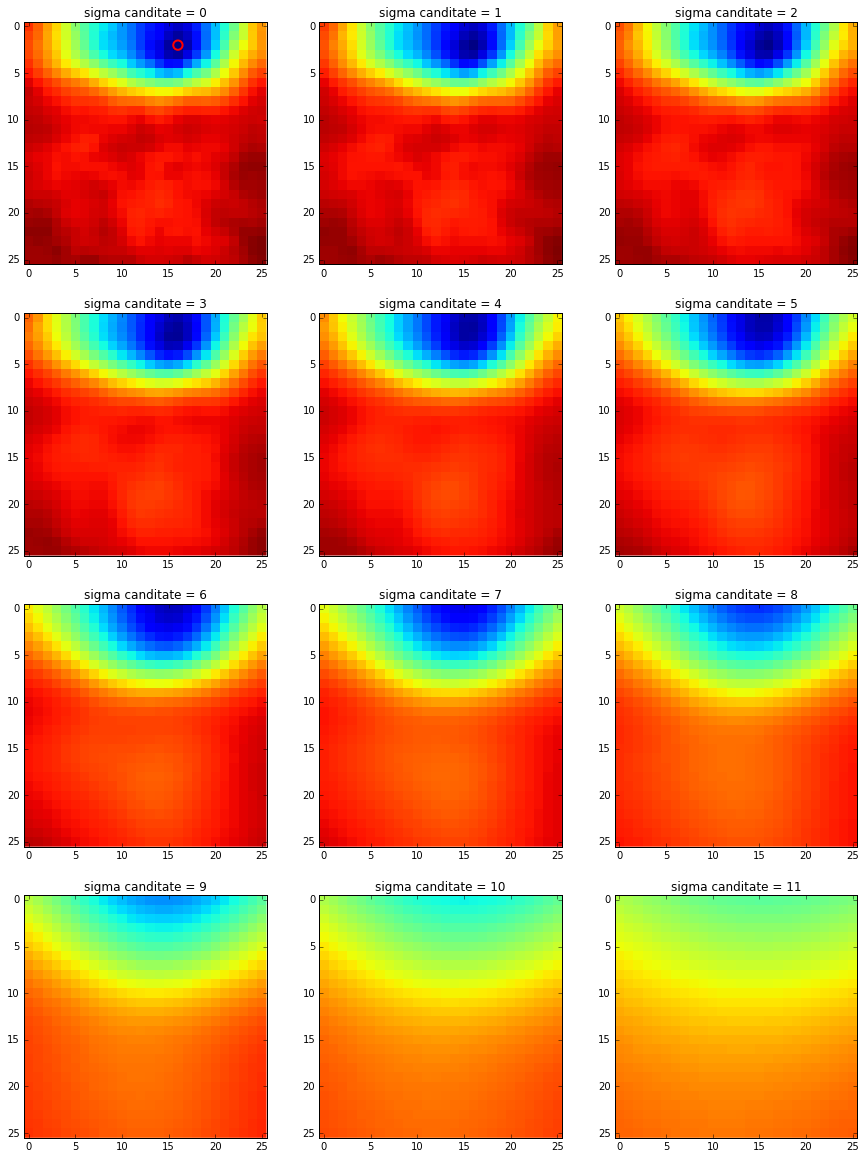

In [33]:
vidx = 3566
print best_abs_models[vidx,:]
fig1 = display_candidate_loss(val_scores[-1,vidx,:], nx, ny, ns)

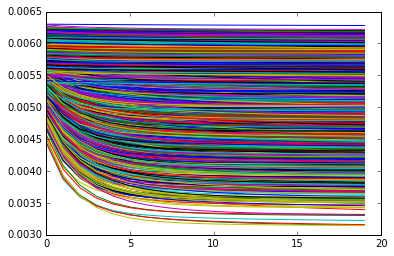

In [34]:
for v in range(val_scores.shape[1]):
    plt.plot(val_scores[:,v,best_rel_models[v]])

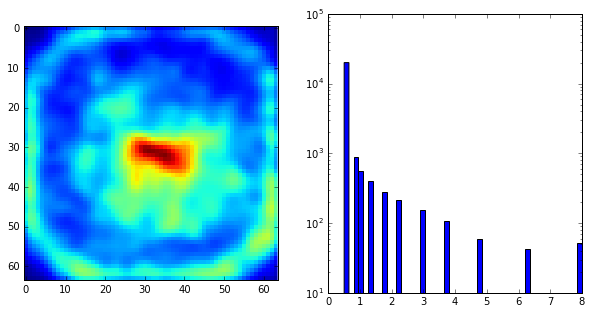

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_,_,g_stack = pnu.make_gaussian_stack(best_abs_models[:,0], best_abs_models[:,1], best_abs_models[:,2], 64, size=20., dtype=fpX)
plt.imshow(np.sum(g_stack, axis=0), interpolation='None')
plt.subplot(1,2,2)
_=plt.hist(best_abs_models[:,2], bins=50)
plt.yscale('log')

In [36]:
print best_abs_models.shape
print best_abs_models.dtype

(22701, 3)
float32


# Test the models for validation CC

In [37]:
val_pred, val_cc = fwrf.validate_models(val_rfw_data, valVoxelData, best_rel_models, best_params, use_data_as_rfw_data=True)

16 voxel batches of size 1352 with residual 1069


17it [00:01,  8.89it/s]


argmax cc = 16161
max cc = 0.818471
sum(cc>0.2) = 2817


(-0.4, 0.9)

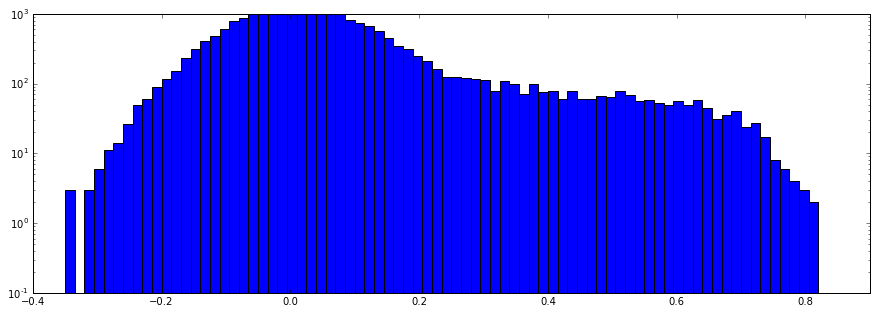

In [38]:
print "argmax cc = %d" % np.argmax(val_cc)
print "max cc = %f" % np.max(val_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_cc))
plt.figure(figsize=(15,5))
_=plt.hist(val_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

[[ 1.          0.74329702]
 [ 0.74329702  1.        ]]


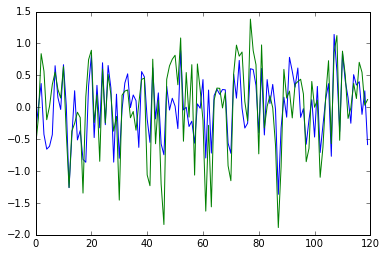

In [39]:
plt.plot(val_pred[:,vidx])
plt.plot(valVoxelData[:,vidx])

print np.corrcoef(val_pred[:,vidx], valVoxelData[:,vidx])

In [ ]:
***

In [40]:
ex_file_name = output_dir + "fwrf_%s_%s_%s_data.pkl" % (model_name, subject, timestamp)
ex_file = open(ex_file_name, 'wb')
ex_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes,      
             'scores': best_scores,
             'models': best_abs_models,
             'params': best_params,
             'val_pred': val_pred,
             'val_cc': val_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

/home/styvesg/Documents/PostDoc/Programs/JupyterNotebooks/fwrf-master/output/fwrf_S1_Mar-24-2017_1455_data.pkl


In [41]:
#data_file = open(output_dir + "fwrf_model_S1_Feb-17-2017_1812.pkl", 'rb')
#data_value = pickle.load(data_file)
#data_file.close()

# Split accuracy by layer and roi

In [42]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]


In [43]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_params[0][:, partitions[l]:partitions[l+1]]
    partition_params[1][:] = best_params[1][:]

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.validate_models(val_rfw_data, valVoxelData, best_rel_models, partition_params, use_data_as_rfw_data=True)

16 voxel batches of size 1352 with residual 1069


17it [00:01,  8.69it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.74it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.81it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.80it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.59it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.71it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.68it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.86it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.76it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.74it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.87it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.75it/s]


In [44]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], valVoxelData[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], valVoxelData[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [45]:
part_file = open(output_dir + "fwrf_%s_%s_%s_part.pkl" % (model_name, subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'val_pred': partition_val_pred,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [46]:
nROI = int(np.max(voxelROI))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxelROI.flatten()==roi, val_cc>0.2)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask] /  val_cc[roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

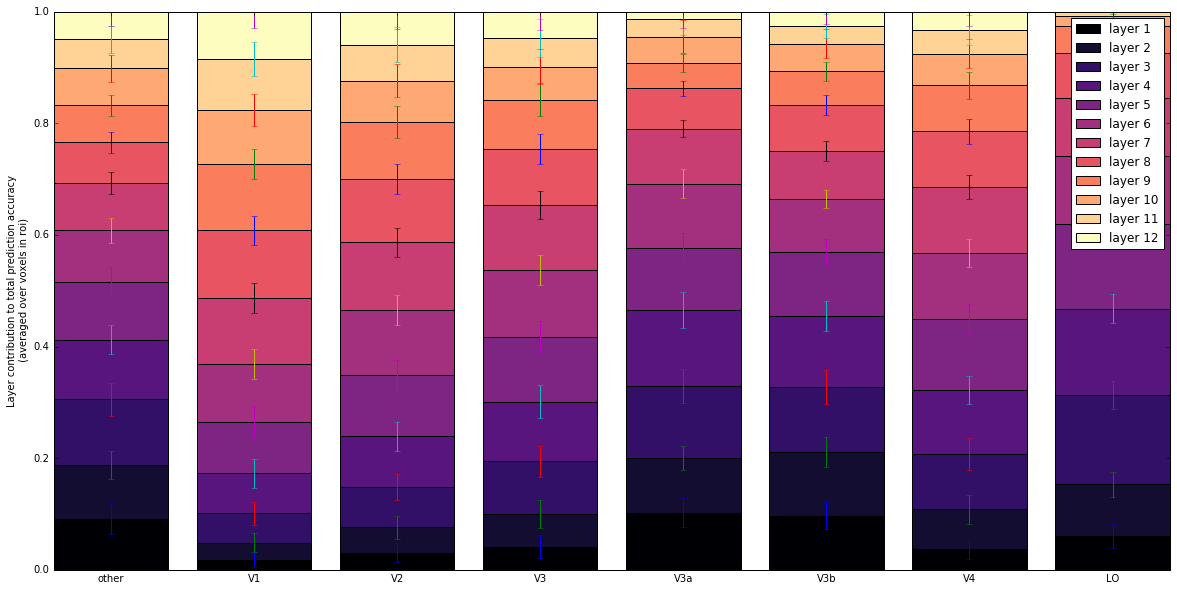

In [47]:
from matplotlib.pyplot import cm 
color=iter(cm.magma(np.linspace(0,1,nL)))

plt.figure(figsize=(20,10))
c=next(color)
plist = []
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], yerr=partition_R_std[0,:], color=c, align='center')
plist += [_,]
for l in range(1,nL):
    c=next(color)
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), yerr=partition_R_std[l,:], color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
plt.ylim([0,1])
plt.ylabel('Layer contribution to total prediction accuracy\n (averaged over voxels in roi)')